In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sympy
from sympy import init_printing
init_printing()
from celmech import Poincare,PoincareHamiltonian
from celmech.nbody_simulation_utilities import align_simulation

from celmech.symplectic_evolution_operators import LinearSecularEvolutionOperator
from celmech.symplectic_evolution_operators import SecularDFTermsEvolutionOperator
from celmech.secular import LaplaceLagrangeSystem, SecularSystemSimulation
import rebound as rb
COMPARE = False # Set true to compare numerical results from operator to sympy

In [2]:
def get_sim(scale= 0.05):
    sim = rb.Simulation()
    sim.add(m=1)
    for i in range(1,4):
        sim.add(m=i * 1e-5 , a = 2**i, 
                e = np.random.rayleigh(scale),
                inc = np.random.rayleigh(scale),
                l = 'uniform',
                pomega = 'uniform',
                Omega = 'uniform'
               )
    sim.move_to_com()
    align_simulation(sim)
    return sim

# Initialize simulation objects and evolution operators

In [3]:
np.random.seed(123)
sim = get_sim()
pvars = Poincare.from_Simulation(sim)
llsys = LaplaceLagrangeSystem.from_Poincare(pvars)
sec_sim = SecularSystemSimulation(state=pvars,dtFraction=(1 / 50) , max_order=4)

# Integration

## numerical secular model

In [4]:
Tfin = sec_sim.dt * 1e3
N = 200

In [5]:
def run_secular_sim(sec_sim,times):
    N = len(times)
    eccN,incN = np.zeros((2,sec_sim.state.N - 1,N))
    EnergyN = np.zeros(N)
    timesDone = np.zeros(N)
    for i,time in enumerate(times):
        sec_sim.integrate(time)
        timesDone[i] = sec_sim.t
        EnergyN[i] = sec_sim.calculate_energy()
        for j,p in enumerate(sec_sim.state.particles[1:]):
            eccN[j,i] = p.e
            incN[j,i] = p.inc
    return timesDone,EnergyN,eccN,incN

In [7]:
T = np.linspace(0,Tfin,N)
%time times,EnergyN,eccN,incN = run_secular_sim(sec_sim,T)

/Users/shadden/Projects/celmech/celmech/symplectic_evolution_operators.py:1013: UserWarning: Implicit step failed to converge.
  warnings.warn("Implicit step failed to converge.")


CPU times: user 3.01 s, sys: 39.5 ms, total: 3.05 s
Wall time: 3.21 s


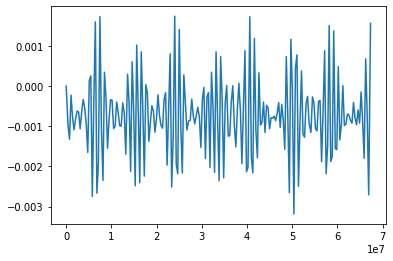

In [8]:
plt.plot(times,(EnergyN - EnergyN[0]) / EnergyN[0])

## $N$-body

In [9]:
from celmech.nbody_simulation_utilities import set_timestep,get_simarchive_integration_results
sim.integrator = 'whfast'
set_timestep(sim,1/30.)
sim.ri_whfast.safe_mode=0
sim.automateSimulationArchive('sa_secular.bin',interval=times[1],deletefile=True)

In [10]:
%time sim.integrate(times[-1])

CPU times: user 1min 20s, sys: 1.4 s, total: 1min 21s
Wall time: 1min 40s


In [11]:
nbody_results = get_simarchive_integration_results(rb.SimulationArchive('./sa_secular.bin'))

## Laplace-Lagrange solution

In [12]:
llsoln = llsys.secular_solution(times)

## Comparison

In [13]:
Tsec = 50 * sec_sim.dt

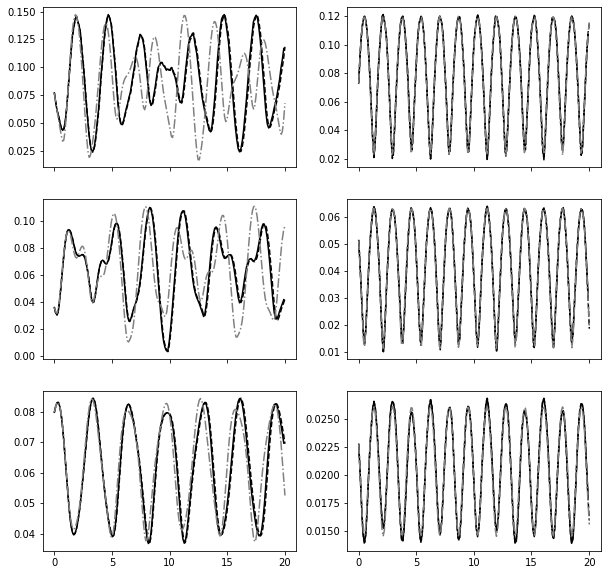

In [15]:
fig,ax = plt.subplots(3,2,figsize=(10,10),sharex=True)
for i in range(3):
    ax[i,0].plot(nbody_results['time']/Tsec,nbody_results['e'][i],color='k')
    ax[i,0].plot(times/Tsec,eccN[i],'--',color='k')
    ax[i,0].plot(times/Tsec,llsoln['e'][i],ls='-.',color='gray')
    
    ax[i,1].plot(nbody_results['time']/Tsec,nbody_results['inc'][i],color='k')
    ax[i,1].plot(times/Tsec,incN[i],'--',color='k')
    ax[i,1].plot(times/Tsec,llsoln['inc'][i],ls='-.',color='gray')